# 1. EEG Emotion detection from AF7 node:

In [28]:
# 1. Importing Necessary Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 2. Loading and Filtering Data for AF7 Features

In [29]:
# 2. Loading and Filtering Data for AF7-Like Features
# Load the dataset
file_path = 'emotions.csv'  # Upload this file to Colab
data = pd.read_csv(file_path)

# Identify columns with EEG signal information (mean, std, fft, moments) as a proxy for AF7 data
signal_columns = [col for col in data.columns if any(keyword in col.lower() for keyword in ['mean', 'std', 'fft', 'moments'])]

# Preview signal columns
print("Identified Signal Columns for Feature Extraction:", signal_columns)

Identified Signal Columns for Feature Extraction: ['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a', 'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a', 'mean_d_0_a2', 'mean_d_1_a2', 'mean_d_2_a2', 'mean_d_3_a2', 'mean_d_4_a2', 'mean_d_5_a', 'mean_d_6_a', 'mean_d_7_a', 'mean_d_8_a', 'mean_d_9_a', 'mean_d_10_a', 'mean_d_11_a', 'mean_d_12_a', 'mean_d_13_a', 'mean_d_14_a', 'mean_d_15_a', 'mean_d_16_a', 'mean_d_17_a', 'mean_d_18_a', 'mean_d_19_a', 'mean_d_20_a', 'mean_d_21_a', 'mean_d_22_a', 'mean_d_23_a', 'mean_d_24_a', 'mean_d_25_a', 'mean_d_26_a', 'mean_d_27_a', 'mean_d_28_a', 'mean_d_29_a', 'mean_d_30_a', 'mean_d_31_a', 'mean_d_32_a', 'mean_d_33_a', 'mean_d_34_a', 'mean_d_35_a', 'mean_d_36_a', 'mean_d_37_a', 'mean_d_38_a', 'mean_d_39_a', 'mean_d_40_a', 'mean_d_41_a', 'mean_d_42_a', 'mean_d_43_a', 'mean_d_44_a', 'mean_d_45_a', 'mean_d_46_a', 'mean_d_47_a', 'mean_d_48_a', 'mean_d_49_a', 'stddev_0_a', 'stddev_1_a', 'stddev_2_a', 'stddev_3_a', 'stddev_4_a', 's

# 3.Extracting AF7-Like Features from Signal Data

In [30]:
# 3. Extracting AF7-Like Features from Signal Data
# Calculate statistical summaries (mean, std, min, max, median) across identified signal columns
af7_features = pd.DataFrame({
    'mean': data[signal_columns].mean(axis=1),
    'std_dev': data[signal_columns].std(axis=1),
    'min': data[signal_columns].min(axis=1),
    'max': data[signal_columns].max(axis=1),
    'median': data[signal_columns].median(axis=1)
})

# Add the label column to extracted features
af7_features['label'] = data['label']

# Display a preview of the extracted features
print("Extracted AF7-Like Features:\n", af7_features.head())

Extracted AF7-Like Features:
            mean       std_dev           min           max  median     label
0  5.455444e+11  1.578470e+13 -7.460000e+02  4.680000e+14  -1.015  NEGATIVE
1  2.014355e+07  5.853973e+08 -8.920000e+07  1.780000e+10   5.160   NEUTRAL
2  3.160080e+11  9.221220e+12 -4.730000e+11  3.130000e+14 -30.300  POSITIVE
3  2.769451e+12  8.045856e+13 -3.920000e+12  2.440000e+15   2.655  POSITIVE
4  3.791504e+09  8.348338e+10 -1.200000e+10  2.280000e+12   8.985   NEUTRAL


# 4. Preparing Data for Model Training


In [31]:
# 4. Preparing Data for Model Training
# Separate features and target variable
X = af7_features.drop(columns=['label'])
y = af7_features['label']

# Convert labels to numeric for model compatibility
y = pd.Categorical(y).codes

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check data shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1705, 5)
y_train shape: (1705,)
X_test shape: (427, 5)
y_test shape: (427,)


# 5. Training a Random Forest Model

In [32]:
# 5. Training a Random Forest Model
# Initialize and train a RandomForest classifier as a baseline
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       143
           1       0.89      0.89      0.89       148
           2       0.82      0.75      0.78       136

    accuracy                           0.87       427
   macro avg       0.86      0.86      0.86       427
weighted avg       0.86      0.87      0.86       427

Random Forest Accuracy: 0.8665105386416861


# 6. Implementing the One Rule Classifier


In [36]:
# Reset indices of X_train, X_test, y_train, and y_test to ensure alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Define the One Rule Classifier function
def one_rule_classifier(X_train, y_train, X_test, y_test):
    best_feature = None
    best_rule = None
    best_accuracy = 0
    best_predictions = None

    for feature in X_train.columns:
        # Generate the rule based on the most common label for each value of the feature
        rule = {}
        for value in X_train[feature].unique():
            # Most common label for this feature value in the training set
            label = y_train[X_train[feature] == value].mode()[0]
            rule[value] = label

        # Make predictions based on this rule
        predictions = X_test[feature].map(rule)

        # Calculate accuracy by comparing to true labels
        accuracy = accuracy_score(y_test, predictions.fillna(y_train.mode()[0]))  # Fill NaNs with most common label

        # If this rule is the best so far, store it
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature
            best_rule = rule
            best_predictions = predictions.fillna(y_train.mode()[0])

    return best_feature, best_rule, best_predictions, best_accuracy

# Train and evaluate the One Rule classifier
best_feature, best_rule, predictions, accuracy = one_rule_classifier(X_train, y_train, X_test, y_test)

# Print the results
print(f"Best Feature for One Rule: {best_feature}")
print(f"One Rule: {best_rule}")
print(f"One Rule Classifier Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report(y_test, predictions))


Best Feature for One Rule: max
One Rule: {14900000000.0: 1, 17000000000.0: 2, 1080000000000000.0: 2, 66400000000000.0: 0, 5460000000000000.0: 0, 346000000000000.0: 0, 26900000000.0: 2, 313000000000000.0: 2, 24800000000.0: 1, 94800000000000.0: 2, 277000000000000.0: 0, 29200000000.0: 2, 169000000000000.0: 2, 44000000000.0: 2, 66700000000.0: 1, 327000000000.0: 0, 13500000000000.0: 1, 1690000000000000.0: 2, 118000000000000.0: 2, 8530000000000000.0: 0, 135000000000000.0: 2, 4760000000000000.0: 0, 17600000000.0: 2, 481000000000000.0: 0, 1.01e+16: 0, 16000000000.0: 1, 648000000000000.0: 0, 12400000000.0: 1, 35500000000.0: 2, 1360000000000000.0: 0, 42400000000.0: 1, 29800000000.0: 1, 219000000000000.0: 2, 633000000000000.0: 0, 79300000000.0: 2, 24300000000.0: 2, 17400000000.0: 1, 10100000000.0: 1, 16900000000.0: 2, 22000000000.0: 1, 39900000000.0: 1, 499000000000.0: 2, 11700000000.0: 1, 8830000000.0: 1, 24400000000.0: 1, 29500000000.0: 2, 10700000000.0: 1, 111000000000000.0: 0, 266000000000000

# 7. Training a Neural Network Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the neural network model with additional layers
nn_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer with 128 neurons
    Dropout(0.4),                                               # Dropout to prevent overfitting
    Dense(64, activation='relu'),                               # Second hidden layer with 64 neurons
    Dropout(0.3),                                               # Dropout layer
    Dense(32, activation='relu'),                               # Third hidden layer with 32 neurons
    Dropout(0.3),                                               # Additional Dropout layer
    Dense(3, activation='softmax')                              # Output layer for 3 classes (adjust if needed)
])

# Compile the model
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary to see the architecture
nn_model.summary()

# Train the model
history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,203 (43.76 KB)

 Trainable params: 11,203 (43.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3329 - loss: 909651591823360.0000 - val_accuracy: 0.3349 - val_loss: 6963254001664.0000
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3300 - loss: 100270373601280.0000 - val_accuracy: 0.3185 - val_loss: 16376174477312.0000
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3528 - loss: 127782029885440.0000 - val_accuracy: 0.3349 - val_loss: 8353375846400.0000
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3372 - loss: 345581725679616.0000 - val_accuracy: 0.3349 - val_loss: 24934118064128.0000
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3485 - loss: 150097966923776.0000 - val_accuracy: 0.3349 - val_loss: 27193719652352.0000
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3331 - loss: 266111207604224.0000 - val_accuracy: 0.3349 - val_loss: 39230906564608.0000
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3303 - loss: 3737679

# 8. Model Evaluation and Comparison


Best Feature for One Rule Model: max
One Rule Model Accuracy: 0.585480093676815

Classification Report for One Rule Model:
               precision    recall  f1-score   support

           0       0.90      0.45      0.60       143
           1       0.73      0.59      0.65       148
           2       0.42      0.73      0.53       136

    accuracy                           0.59       427
   macro avg       0.68      0.59      0.59       427
weighted avg       0.69      0.59      0.60       427



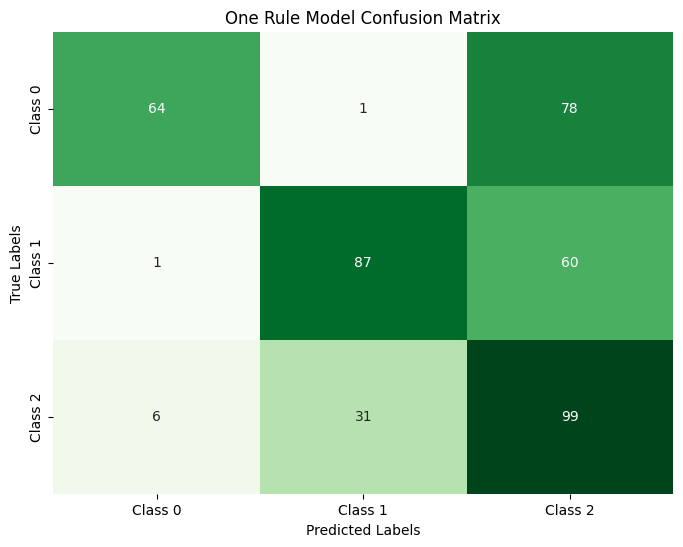

Random Forest Model Accuracy: 0.8665105386416861

Classification Report for Random Forest Model:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       143
           1       0.89      0.89      0.89       148
           2       0.82      0.75      0.78       136

    accuracy                           0.87       427
   macro avg       0.86      0.86      0.86       427
weighted avg       0.86      0.87      0.86       427



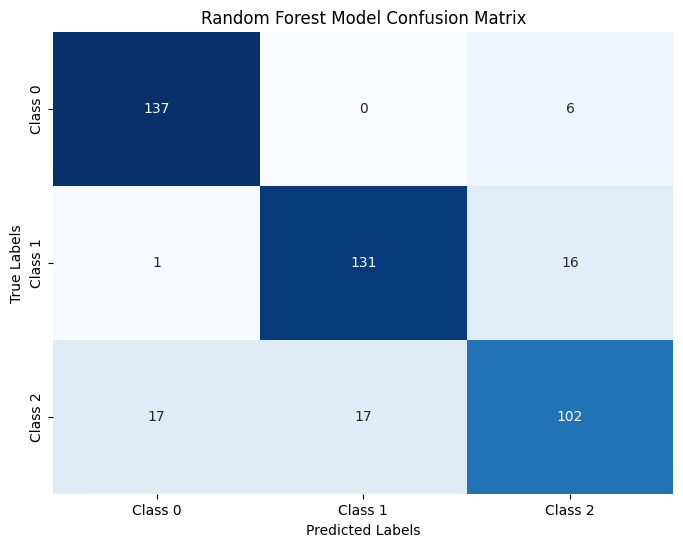

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Network Model Accuracy: 0.33489461358313816

Classification Report for Neural Network Model:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50       143
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       136

    accuracy                           0.33       427
   macro avg       0.11      0.33      0.17       427
weighted avg       0.11      0.33      0.17       427



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


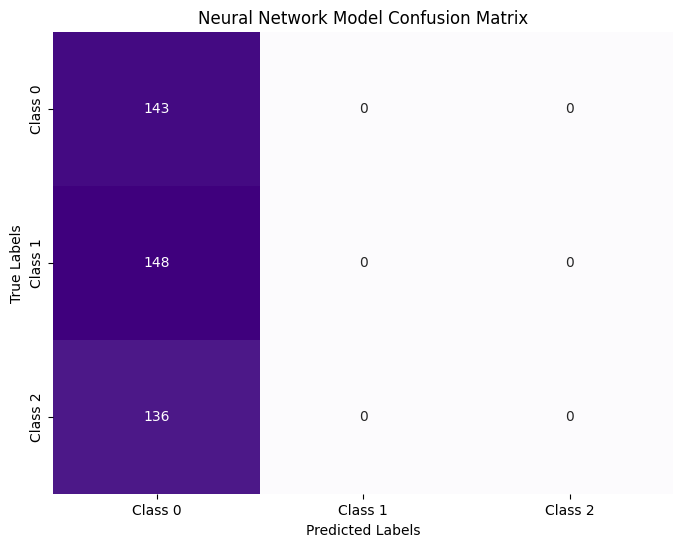

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluate the One Rule (OneR) Model
best_feature, best_rule, one_r_predictions, one_r_accuracy = one_rule_classifier(X_train, y_train, X_test, y_test)
print(f"Best Feature for One Rule Model: {best_feature}")
print(f"One Rule Model Accuracy: {one_r_accuracy}")
print("\nClassification Report for One Rule Model:\n", classification_report(y_test, one_r_predictions))

# Confusion Matrix for One Rule Model
one_r_confusion_mtx = confusion_matrix(y_test, one_r_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(one_r_confusion_mtx, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("One Rule Model Confusion Matrix")
plt.show()

# Evaluate the Random Forest Model
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Model Accuracy: {rf_accuracy}")
print("\nClassification Report for Random Forest Model:\n", classification_report(y_test, rf_predictions))

# Confusion Matrix for Random Forest Model
rf_confusion_mtx = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_confusion_mtx, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random Forest Model Confusion Matrix")
plt.show()

# Evaluate the Neural Network Model
nn_predictions = np.argmax(nn_model.predict(X_test), axis=1)
nn_accuracy = accuracy_score(y_test, nn_predictions)
print(f"Neural Network Model Accuracy: {nn_accuracy}")
print("\nClassification Report for Neural Network Model:\n", classification_report(y_test, nn_predictions))

# Confusion Matrix for Neural Network Model
nn_confusion_mtx = confusion_matrix(y_test, nn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(nn_confusion_mtx, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Neural Network Model Confusion Matrix")
plt.show()